# The above code was for help, now I know what's going on. 

### Let's do this

In [77]:
# ============================================================
# 0. Imports & global settings
# ============================================================

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MOD = 97  # modulus

# For reproducibility
rnd_seed=9
torch.manual_seed(rnd_seed)
np.random.seed(rnd_seed)

Using device: cuda


In [78]:
# ============================================================
# 1. Dataset: modular addition / multiplication on Z_97
# ============================================================

class ModArithDataset(Dataset):
    """
    Generates all pairs (a, b) in {0..MOD-1}^2
    with label f(a,b) = a [+ or *] b (mod MOD).
    """
    def __init__(self, op="add"):
        assert op in ["add", "mul"]
        self.op = op

        xs = []
        ys = []
        for a in range(MOD):
            for b in range(MOD):
                xs.append((a, b))
                if op == "add":
                    ys.append((a + b) % MOD)
                else:
                    ys.append((a * b) % MOD)

        self.x = torch.tensor(xs, dtype=torch.long)  # [N, 2]
        self.y = torch.tensor(ys, dtype=torch.long)  # [N]

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

print("Dataset sizes:")
print("Addition:", len(ModArithDataset("add")))
print("Multiplication:", len(ModArithDataset("mul")))

Dataset sizes:
Addition: 9409
Multiplication: 9409


In [79]:
# ============================================================
# 2. Models: BilinearMLP and ReluMLP
# ============================================================

class BilinearMLP(nn.Module):
    """
    Two-input bilinear MLP:
      e_a = Emb_a[a], e_b = Emb_b[b]
      u = W1(e_a), v = W2(e_b)
      h = u * v (Hadamard)
      logits = W_out(h)
    """
    def __init__(self, num_tokens=MOD, d=32, m=64):
        super().__init__()
        self.emb_a = nn.Embedding(num_tokens, d)
        self.emb_b = nn.Embedding(num_tokens, d)
        self.W1 = nn.Linear(d, m, bias=False)
        self.W2 = nn.Linear(d, m, bias=False)
        self.out = nn.Linear(m, num_tokens, bias=False)

    def forward(self, a, b):
        # a, b: [B] long
        e_a = self.emb_a(a)   # [B, d]
        e_b = self.emb_b(b)   # [B, d]
        u = self.W1(e_a)      # [B, m]
        v = self.W2(e_b)      # [B, m]
        h = u * v             # bilinear interaction
        logits = self.out(h)  # [B, MOD]
        return logits


class ReluMLP(nn.Module):
    """
    Baseline ReLU MLP:
      e_a, e_b embeddings
      x = [e_a; e_b]
      h = ReLU(W(x))
      logits = W_out(h)
    """
    def __init__(self, num_tokens=MOD, d=32, m=64):
        super().__init__()
        self.emb_a = nn.Embedding(num_tokens, d)
        self.emb_b = nn.Embedding(num_tokens, d)
        self.fc1 = nn.Linear(2 * d, m)
        self.out = nn.Linear(m, num_tokens)

    def forward(self, a, b):
        e_a = self.emb_a(a)
        e_b = self.emb_b(b)
        x = torch.cat([e_a, e_b], dim=-1)  # [B, 2d]
        h = F.relu(self.fc1(x))            # [B, m]
        logits = self.out(h)               # [B, MOD]
        return logits

In [80]:
# ============================================================
# 3. Generic training loop
# ============================================================

def train_model(model, dataset, epochs=200, batch_size=256, lr=1e-3, verbose_every=20):
    model = model.to(device)
    N = len(dataset)
    n_train = int(0.8 * N)
    n_val = N - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for (x, y) in train_loader:
            a, b = x[:, 0].to(device), x[:, 1].to(device)
            y = y.to(device)
            logits = model(a, b)
            loss = criterion(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * y.size(0)
        train_loss = total_loss / n_train

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for (x, y) in val_loader:
                a, b = x[:, 0].to(device), x[:, 1].to(device)
                y = y.to(device)
                logits = model(a, b)
                pred = logits.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)

        if (epoch % verbose_every) == 0 or epoch == epochs - 1:
            print(f"[epoch {epoch:3d}] loss={train_loss:.4f}  val_acc={val_acc:.4f}")
            if(val_acc>0.999):
                print("Early Stopping Triggered!")
                break

    return model, history

In [81]:
# ============================================================
# 4. Train models for ADDITION
# ============================================================

add_dataset = ModArithDataset(op="add")

bilinear_add = BilinearMLP(d=32, m=64)
relu_add     = ReluMLP(d=32, m=64)

print("Training Bilinear MLP on addition...")
bilinear_add, hist_b_add = train_model(bilinear_add, add_dataset, epochs=2000)

print("\nTraining ReLU MLP on addition...")
relu_add, hist_r_add = train_model(relu_add, add_dataset, epochs=2000)

Training Bilinear MLP on addition...
[epoch   0] loss=4.5926  val_acc=0.0064
[epoch  20] loss=3.4739  val_acc=0.0202
[epoch  40] loss=0.5599  val_acc=0.4575
[epoch  60] loss=0.0376  val_acc=0.7460
[epoch  80] loss=0.0093  val_acc=0.8066
[epoch 100] loss=0.0039  val_acc=0.8363
[epoch 120] loss=0.0020  val_acc=0.8544
[epoch 140] loss=0.0011  val_acc=0.8709
[epoch 160] loss=0.0007  val_acc=0.8820
[epoch 180] loss=0.0004  val_acc=0.8895
[epoch 200] loss=0.0003  val_acc=0.8969
[epoch 220] loss=0.0002  val_acc=0.9033
[epoch 240] loss=0.0001  val_acc=0.9118
[epoch 260] loss=0.0001  val_acc=0.9187
[epoch 280] loss=0.0001  val_acc=0.9230
[epoch 300] loss=0.0000  val_acc=0.9261
[epoch 320] loss=0.0000  val_acc=0.9325
[epoch 340] loss=0.0000  val_acc=0.9341
[epoch 360] loss=0.0000  val_acc=0.9389
[epoch 380] loss=0.0000  val_acc=0.9431
[epoch 400] loss=0.0000  val_acc=0.9463
[epoch 420] loss=0.0000  val_acc=0.9469
[epoch 440] loss=0.0000  val_acc=0.9495
[epoch 460] loss=0.0000  val_acc=0.9506
[ep

In [82]:
# ============================================================
# 5. Train models for MULTIPLICATION
# ============================================================

mul_dataset = ModArithDataset(op="mul")

bilinear_mul = BilinearMLP(d=32, m=64)
relu_mul     = ReluMLP(d=32, m=64)

print("Training Bilinear MLP on multiplication...")
bilinear_mul, hist_b_mul = train_model(bilinear_mul, mul_dataset, epochs=2000)

print("\nTraining ReLU MLP on multiplication...")
relu_mul, hist_r_mul = train_model(relu_mul, mul_dataset, epochs=2000)

Training Bilinear MLP on multiplication...
[epoch   0] loss=4.5896  val_acc=0.0138
[epoch  20] loss=3.5505  val_acc=0.0202
[epoch  40] loss=0.7638  val_acc=0.3879
[epoch  60] loss=0.0918  val_acc=0.7540
[epoch  80] loss=0.0333  val_acc=0.8310
[epoch 100] loss=0.0114  val_acc=0.8640
[epoch 120] loss=0.0027  val_acc=0.8847
[epoch 140] loss=0.0014  val_acc=0.9017
[epoch 160] loss=0.0008  val_acc=0.9102
[epoch 180] loss=0.0005  val_acc=0.9160
[epoch 200] loss=0.0003  val_acc=0.9235
[epoch 220] loss=0.0002  val_acc=0.9309
[epoch 240] loss=0.0001  val_acc=0.9373
[epoch 260] loss=0.0001  val_acc=0.9431
[epoch 280] loss=0.0001  val_acc=0.9453
[epoch 300] loss=0.0000  val_acc=0.9463
[epoch 320] loss=0.0000  val_acc=0.9501
[epoch 340] loss=0.0000  val_acc=0.9522
[epoch 360] loss=0.0000  val_acc=0.9538
[epoch 380] loss=0.0000  val_acc=0.9548
[epoch 400] loss=0.0000  val_acc=0.9586
[epoch 420] loss=0.0000  val_acc=0.9607
[epoch 440] loss=0.0000  val_acc=0.9617
[epoch 460] loss=0.0000  val_acc=0.96

In [83]:
torch.save(bilinear_add, "/kaggle/working/bilinear_add.pth")
torch.save(bilinear_mul, "/kaggle/working/bilinear_mul.pth")
torch.save(relu_mul, "/kaggle/working/relu_mul.pth")
torch.save(relu_add, "/kaggle/working/relu_add.pth")

# bilinear_add = torch.load('/kaggle/input/weightss/bilinear_add.pth')
# bilinear_mul = torch.load('/kaggle/input/weightss/bilinear_mul.pth')
# relu_add = torch.load('/kaggle/input/weightss/relu_add.pth')
# relu_mul = torch.load('/kaggle/input/weightss/relu_mul.pth')

In [84]:
# ============================================================
# 6. Utility: build full logits grid for all (a,b)
# ============================================================

def full_logits_grid(model):
    """
    Return logits[a,b,k] for all a,b ∈ {0..MOD-1}.
    model is already trained.
    """
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        a_idx = torch.arange(MOD, device=device)
        b_idx = torch.arange(MOD, device=device)
        A, B = torch.meshgrid(a_idx, b_idx, indexing="ij")  # [MOD,MOD]
        A_flat = A.reshape(-1)
        B_flat = B.reshape(-1)
        logits = model(A_flat, B_flat)  # [MOD*MOD, MOD]
        logits = logits.reshape(MOD, MOD, MOD)  # [a,b,k]
    return logits.cpu().numpy()


In [85]:
# ============================================================
# 7. Extract Mk from Bilinear weights (weight-level)
# ============================================================

def extract_Mk_bilinear_from_weights(model: BilinearMLP):
    """
    Analytic extraction of M_k[a,b] from bilinear weights.
    Returns Mk: numpy array of shape [MOD, MOD, MOD] where Mk[a,b,k].
    """
    model = model.to(device)
    with torch.no_grad():
        # Embeddings: [MOD, d]
        E_a = model.emb_a.weight.data.clone().to(device)
        E_b = model.emb_b.weight.data.clone().to(device)

        # Linear weights: nn.Linear stores weight [out_dim, in_dim]
        # We want W1: [d,m], W2: [d,m], out: [m,MOD]
        W1 = model.W1.weight.data.clone().to(device).T   # [d, m]
        W2 = model.W2.weight.data.clone().to(device).T   # [d, m]
        O  = model.out.weight.data.clone().to(device).T  # [m, MOD]

        # U[a,j] = e_a W1[:,j]
        U = E_a @ W1      # [MOD, m]
        V = E_b @ W2      # [MOD, m]

        U_np = U.cpu().numpy()   # [MOD, m]
        V_np = V.cpu().numpy()   # [MOD, m]
        O_np = O.cpu().numpy()   # [m, MOD]

    # hidden_pair[a,b,j] = U[a,j] * V[b,j]
    A = U_np[:, None, :]    # [MOD, 1, m]
    B = V_np[None, :, :]    # [1, MOD, m]
    hidden_pair = A * B     # [MOD, MOD, m]

    # Contract hidden dimension with out weights:
    # Mk[a,b,k] = sum_j hidden_pair[a,b,j] * O[j,k]
    Mk = np.einsum("abm,mk->abk", hidden_pair, O_np)  # [MOD, MOD, MOD]
    return Mk


In [86]:
# ============================================================
# 8. Alternate: Mk directly from logits for ANY model
# ============================================================

def extract_Mk_from_logits(model):
    """
    For any model, simply interpret the logits grid as M_k[a,b].
    i.e., M_k[a,b] = logits_k(a,b).
    This is exact for discrete domain, though not weight-analytic.
    """
    logits = full_logits_grid(model)  # [a,b,k]
    return logits  # same shape [MOD,MOD,MOD]


In [87]:
Mk_add_bilin_w  = extract_Mk_bilinear_from_weights(bilinear_add)
Mk_add_bilin_act = extract_Mk_from_logits(bilinear_add)
Mk_add_relu_act  = extract_Mk_from_logits(relu_add)

Mk_mul_bilin_w  = extract_Mk_bilinear_from_weights(bilinear_mul)
Mk_mul_bilin_act = extract_Mk_from_logits(bilinear_mul)
Mk_mul_relu_act  = extract_Mk_from_logits(relu_mul)

In [88]:
# ============================================================
# 9. Fourier analysis (addition) – entropy per class
# ============================================================

def fourier_entropy(Mk):
    """
    Mk: numpy array [MOD, MOD, MOD]  (a,b,k)
    Returns: entropies H_k for each k.
    """
    N = Mk.shape[0]
    # DFT matrix F[u,a] = exp(-2πi * u*a / N) / sqrt(N)
    n = np.arange(N)
    omega = np.exp(-2j * np.pi / N)
    F = omega ** np.outer(n, n) / np.sqrt(N)  # [N,N], complex

    H = []
    for k in range(N):
        M = Mk[:, :, k]
        M_hat = F @ M @ F.conj().T    # [N,N] complex
        power = np.abs(M_hat) ** 2
        power = power / power.sum()
        p = power.flatten()
        p = p[p > 0]                  # avoid log(0)
        H_k = -np.sum(p * np.log(p))
        H.append(H_k)
    return np.array(H)

# Compute entropies for addition
H_add_bilin = fourier_entropy(Mk_add_bilin_w)
H_add_relu  = fourier_entropy(Mk_add_relu_act)

print("Mean entropy (add, bilinear):", H_add_bilin.mean())
print("Mean entropy (add, relu):    ", H_add_relu.mean())


Mean entropy (add, bilinear): 4.267357477932346
Mean entropy (add, relu):     0.419208480218371


In [89]:
import matplotlib as mpl 
mpl.rcParams.update({ "figure.dpi": 500,
                     "savefig.dpi": 500,
                         # Font sizes (COMMONLY USED)
                        "axes.titlesize": 10,              # figure title
                        "axes.labelsize": 9,               # axis labels
                        "xtick.labelsize": 8,
                        "ytick.labelsize": 8,
                        "legend.fontsize": 8,})

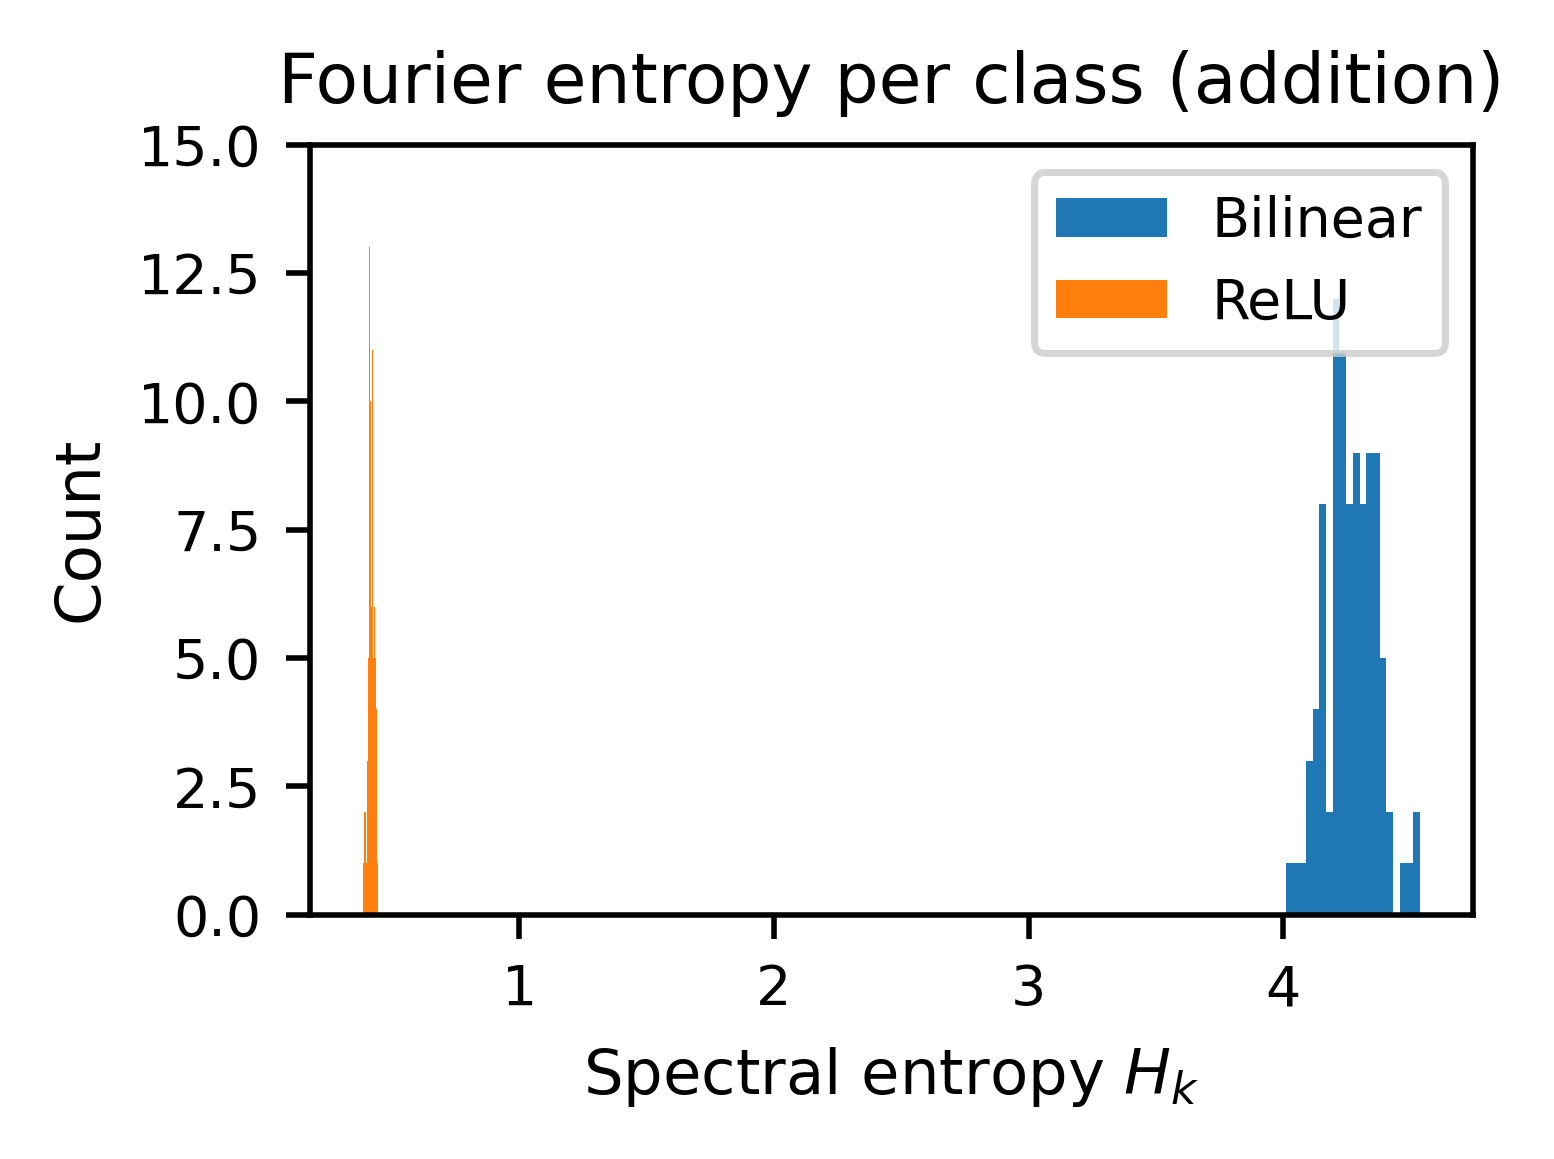

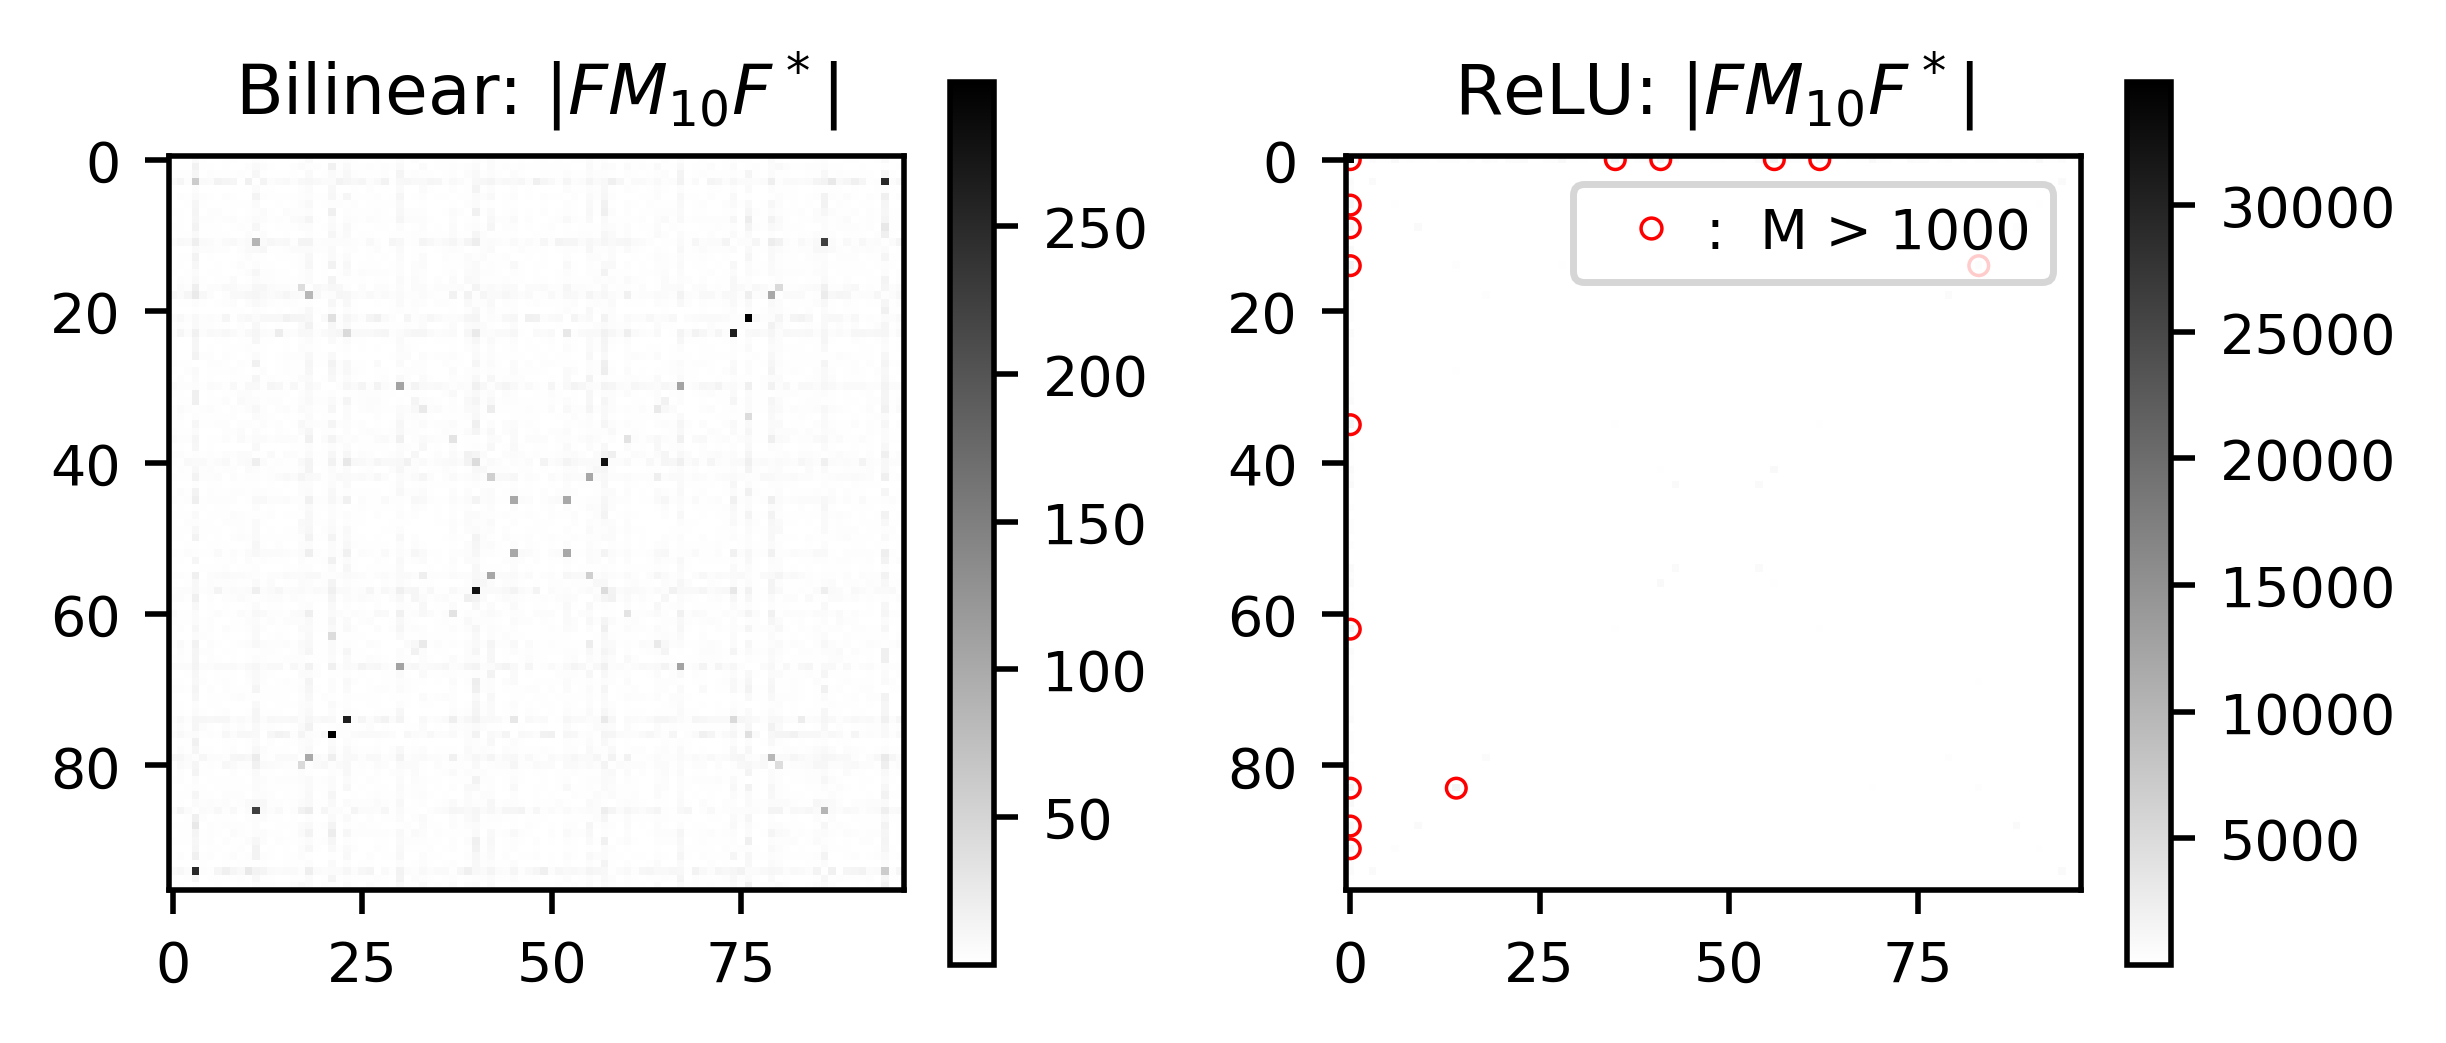

In [90]:
# ============================================================
# 10. Plot entropy histograms & example Fourier heatmaps
# ============================================================

from matplotlib.lines import Line2D
# Histogram comparison
plt.figure(figsize=(3,2))
plt.hist(H_add_bilin, bins=20, alpha=1, label="Bilinear")
plt.hist(H_add_relu,  bins=20, alpha=1, label="ReLU")
plt.xlabel(r"Spectral entropy $H_k$")
plt.ylabel("Count")
plt.title("Fourier entropy per class (addition)")
plt.ylim(0, 15) 
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/entropy_per_class', format="pdf", bbox_inches="tight")
plt.show()

# Example Fourier heatmaps for a chosen class, say k=10
k_example = 10
N = MOD
n = np.arange(N)
omega = np.exp(-2j * np.pi / N)
F = omega ** np.outer(n, n) / np.sqrt(N)

def fourier_heat(Mk, k):
    M = Mk[:, :, k]
    M_hat = F @ M @ F.conj().T
    return np.abs(M_hat)

# compute the matrices
M_bilin = fourier_heat(Mk_add_bilin_w, k_example)
M_relu  = fourier_heat(Mk_add_relu_act, k_example)

# find coordinates where values > 1000
y_bilin, x_bilin = np.where(M_bilin > 1000)
y_relu,  x_relu  = np.where(M_relu > 1000)

plt.figure(figsize=(5,2.2))

# ---- Bilinear ----
plt.subplot(1,2,1)
plt.imshow(M_bilin, cmap="gray_r")
plt.title(rf"Bilinear: $|F M_{{{k_example}}} F^*|$")
plt.colorbar()

# scatter red circles
plt.scatter(x_bilin, y_bilin,
            facecolors='none', edgecolors='red', s=8, linewidths=0.5)

# ---- ReLU ----
plt.subplot(1,2,2)
plt.imshow(M_relu, cmap="gray_r")
plt.title(rf"ReLU: $|F M_{{{k_example}}} F^*|$")
plt.colorbar()

plt.scatter(x_relu, y_relu,
            facecolors='none', edgecolors='red', s=8, linewidths=0.5)

red_circle = Line2D(
    [], [], 
    color='red',
    marker='o',
    linestyle='None',
    markerfacecolor='none',

    markersize=3,          # ← make the circle larger (default ~8)
    markeredgewidth=0.5     # ← make the circle outline thicker
)

plt.legend([red_circle], [":  M > 1000"], loc='upper right', handletextpad=0.001)

plt.tight_layout()
plt.savefig('/kaggle/working/heatmap.pdf', format="pdf", bbox_inches="tight")
plt.show()



In [91]:
# ============================================================
# 11. SVD / effective rank analysis (multiplication)
# ============================================================

def svd_effective_rank(Mk, thresh=0.9):
    """
    Mk: [MOD,MOD,MOD]
    Returns: r_k effective rank per class.
    """
    N = Mk.shape[0]
    ranks = []
    for k in range(N):
        M = Mk[:, :, k]
        # SVD
        u, s, vT = np.linalg.svd(M, full_matrices=False)
        s2 = s ** 2
        total = s2.sum()
        cum = np.cumsum(s2)
        r = np.searchsorted(cum, thresh * total) + 1
        ranks.append(r)
    return np.array(ranks)

ranks_mul_bilin = svd_effective_rank(Mk_mul_bilin_w)
ranks_mul_relu  = svd_effective_rank(Mk_mul_relu_act)

print("Mean effective rank (mul, bilinear):", ranks_mul_bilin.mean())
print("Mean effective rank (mul, relu):    ", ranks_mul_relu.mean())


Mean effective rank (mul, bilinear): 1.0
Mean effective rank (mul, relu):     1.0


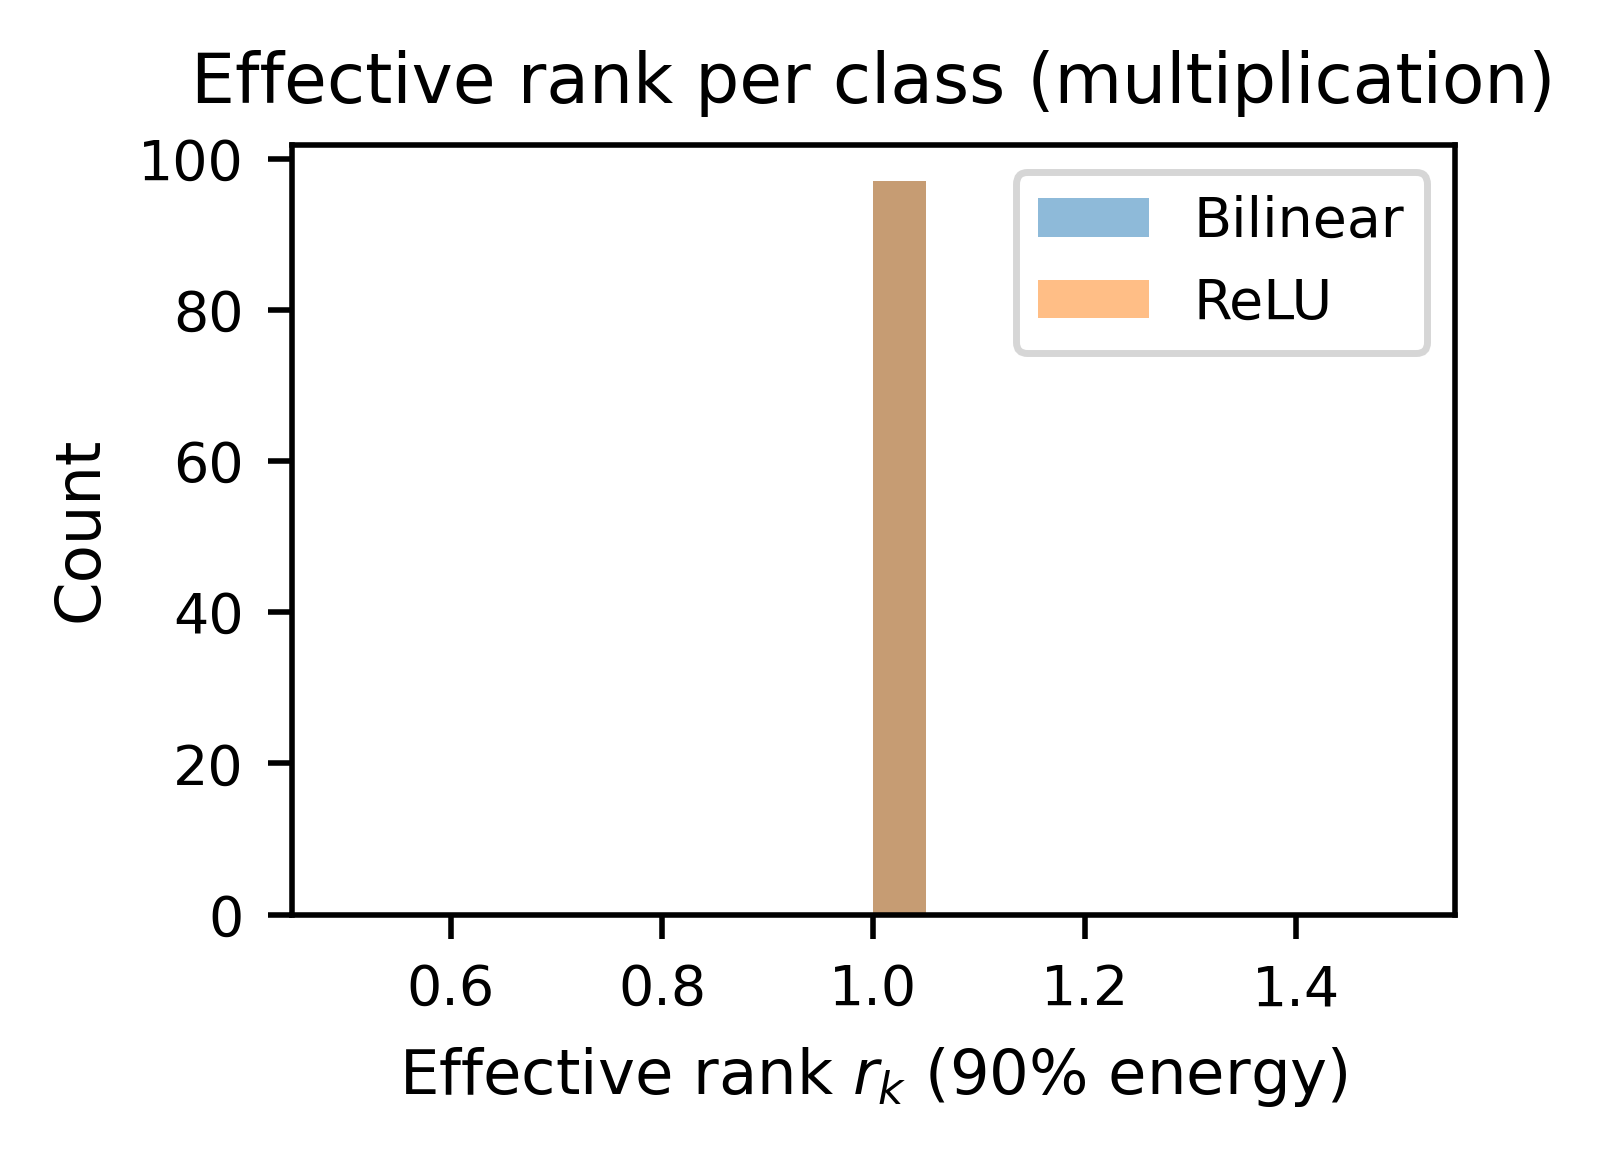

In [92]:
# ============================================================
# 12. Plot rank histograms
# ============================================================

plt.figure(figsize=(3,2))
plt.hist(ranks_mul_bilin, bins=20, alpha=0.5, label="Bilinear")
plt.hist(ranks_mul_relu,  bins=20, alpha=0.5, label="ReLU")
plt.xlabel(r"Effective rank $r_k$ (90% energy)")
plt.ylabel("Count")
plt.title("Effective rank per class (multiplication)")
plt.legend()
plt.savefig('/kaggle/working/eff_rank_mult_90.pdf', format="pdf", bbox_inches="tight")
plt.show()


In [93]:
# ============================================================
# 13. Ground-truth operator for addition and its entropy
# ============================================================

def true_Mk_add():
    """
    Construct the exact modular addition operator as Mk[a,b,k],
    with Mk[a,b,k] = 1 if k == (a+b mod MOD) else 0.
    """
    Mk = np.zeros((MOD, MOD, MOD), dtype=np.float64)
    for a in range(MOD):
        for b in range(MOD):
            k = (a + b) % MOD
            Mk[a, b, k] = 1.0
    return Mk

Mk_true_add = true_Mk_add()
H_true_add = fourier_entropy(Mk_true_add)

print("Mean entropy (true addition):", H_true_add.mean())
print("Std  entropy (true addition):", H_true_add.std())
print("Mean entropy (add, bilinear):", H_add_bilin.mean())
print("Mean entropy (add, relu):    ", H_add_relu.mean())


Mean entropy (true addition): 4.574710978503383
Std  entropy (true addition): 4.3249218835783516e-16
Mean entropy (add, bilinear): 4.267357477932346
Mean entropy (add, relu):     0.419208480218371


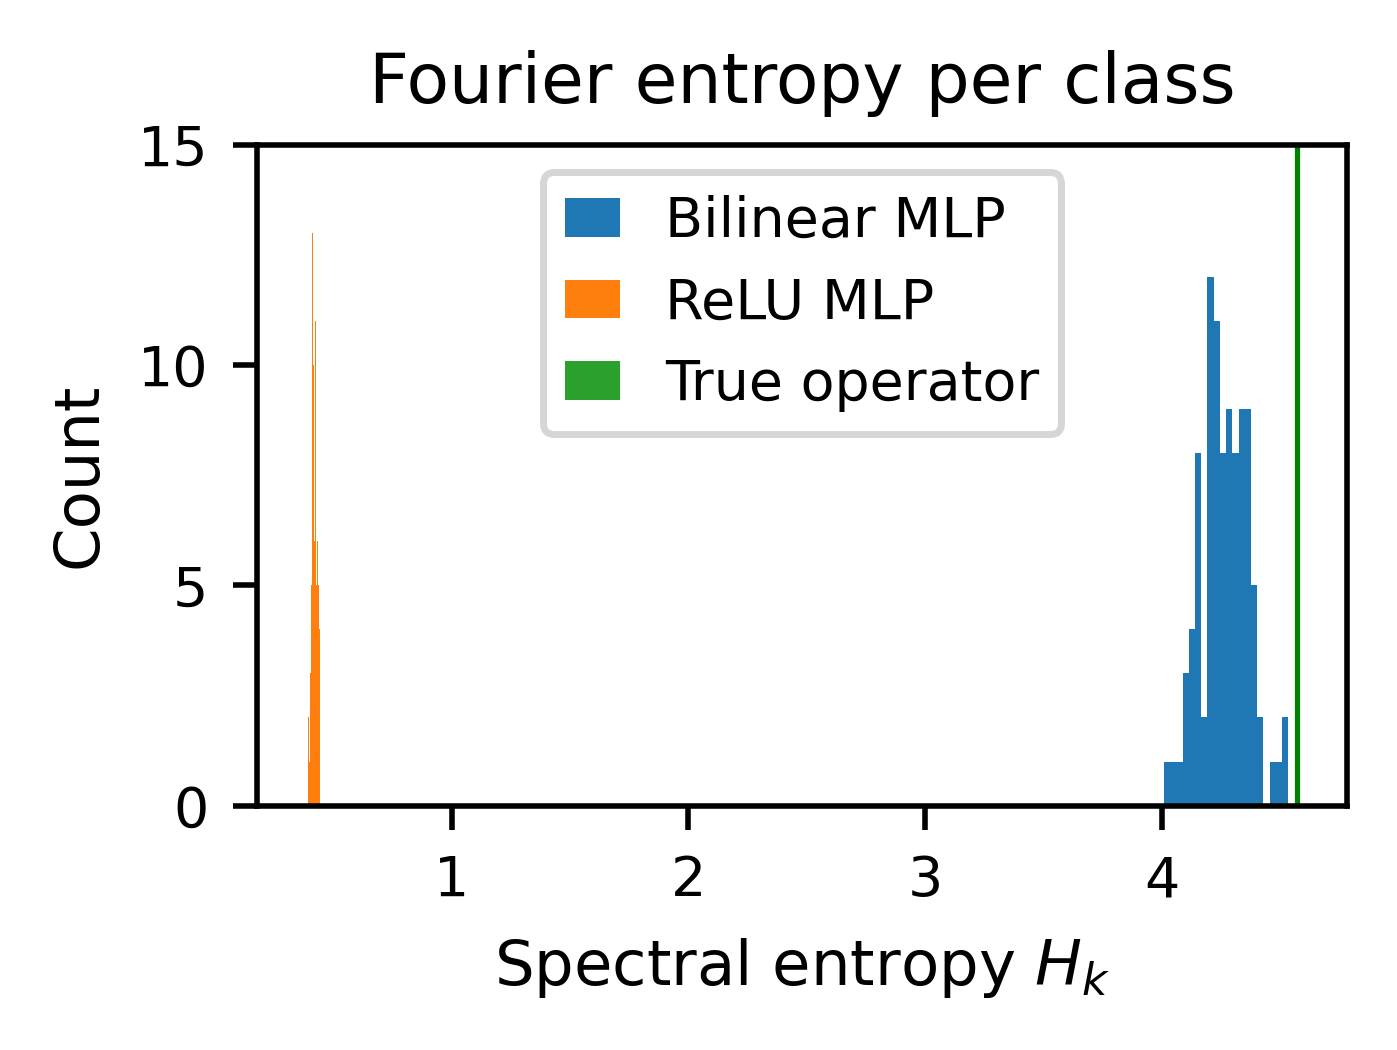

In [94]:
# ============================================================
# 14. Entropy histogram: true vs bilinear vs ReLU (addition)
# ============================================================

plt.figure(figsize=(3,2.2))
plt.hist(H_add_bilin, bins=20, alpha=1, label="Bilinear MLP")
plt.hist(H_add_relu,  bins=20, alpha=1, label="ReLU MLP")
plt.hist(H_true_add,  bins=20, alpha=1, label="True operator")

plt.axvline(H_true_add.mean(), color='green', linewidth=0.75, linestyle='-')
plt.xlabel(r"Spectral entropy $H_k$")
plt.ylabel("Count")
plt.ylim(0, 15) 
plt.title("Fourier entropy per class")
plt.legend(fontsize=8, markerscale=0.7, handlelength=1, loc='upper center')
plt.tight_layout()
plt.savefig('/kaggle/working/fourier_entropy.pdf', format="pdf", bbox_inches="tight")
plt.show()


In [95]:
# ============================================================
# 15. Check Mk from weights vs Mk from logits (bilinear, add)
# ============================================================

Mk_add_bilin_w   = extract_Mk_bilinear_from_weights(bilinear_add)
Mk_add_bilin_act = extract_Mk_from_logits(bilinear_add)

diff_mean = np.abs(Mk_add_bilin_w - Mk_add_bilin_act).mean()
diff_max  = np.abs(Mk_add_bilin_w - Mk_add_bilin_act).max()
print("Mean |Mk_w - Mk_act| (add, bilinear):", diff_mean)
print("Max  |Mk_w - Mk_act| (add, bilinear):", diff_max)


Mean |Mk_w - Mk_act| (add, bilinear): 1.2286858e-06
Max  |Mk_w - Mk_act| (add, bilinear): 1.66893e-05


In [96]:
# ============================================================
# 16. Centered SVD + stricter effective rank for multiplication
# ============================================================

def svd_effective_rank_centered(Mk, thresh=0.9):
    """
    Center each M_k (remove row/col means) and compute effective rank.
    """
    N = Mk.shape[0]
    ranks = []
    for k in range(N):
        M = Mk[:, :, k].astype(np.float64)
        # double-centering
        M = M - M.mean(axis=0, keepdims=True)
        M = M - M.mean(axis=1, keepdims=True)
        M = M + M.mean()
        u, s, vT = np.linalg.svd(M, full_matrices=False)
        s2 = s**2
        total = s2.sum()
        cum = np.cumsum(s2)
        r = np.searchsorted(cum, thresh * total) + 1
        ranks.append(r)
    return np.array(ranks)

# Use logits-based Mk for both models for fairness
Mk_mul_bilin = Mk_mul_bilin_act   # from logits
Mk_mul_relu  = Mk_mul_relu_act    # from logits

r_90_b = svd_effective_rank_centered(Mk_mul_bilin, thresh=0.9)
r_99_b = svd_effective_rank_centered(Mk_mul_bilin, thresh=0.99)

r_90_r = svd_effective_rank_centered(Mk_mul_relu, thresh=0.9)
r_99_r = svd_effective_rank_centered(Mk_mul_relu, thresh=0.99)

print("Centered eff rank (mul, bilinear) 90%:", r_90_b.mean(), "+/-", r_90_b.std())
print("Centered eff rank (mul, relu)     90%:", r_90_r.mean(), "+/-", r_90_r.std())
print("Centered eff rank (mul, bilinear) 99%:", r_99_b.mean(), "+/-", r_99_b.std())
print("Centered eff rank (mul, relu)     99%:", r_99_r.mean(), "+/-", r_99_r.std())


Centered eff rank (mul, bilinear) 90%: 7.051546391752577 +/- 0.737383700711244
Centered eff rank (mul, relu)     90%: 7.917525773195877 +/- 1.1184498024837541
Centered eff rank (mul, bilinear) 99%: 12.649484536082474 +/- 0.8377834908828883
Centered eff rank (mul, relu)     99%: 24.24742268041237 +/- 2.7434304954193642


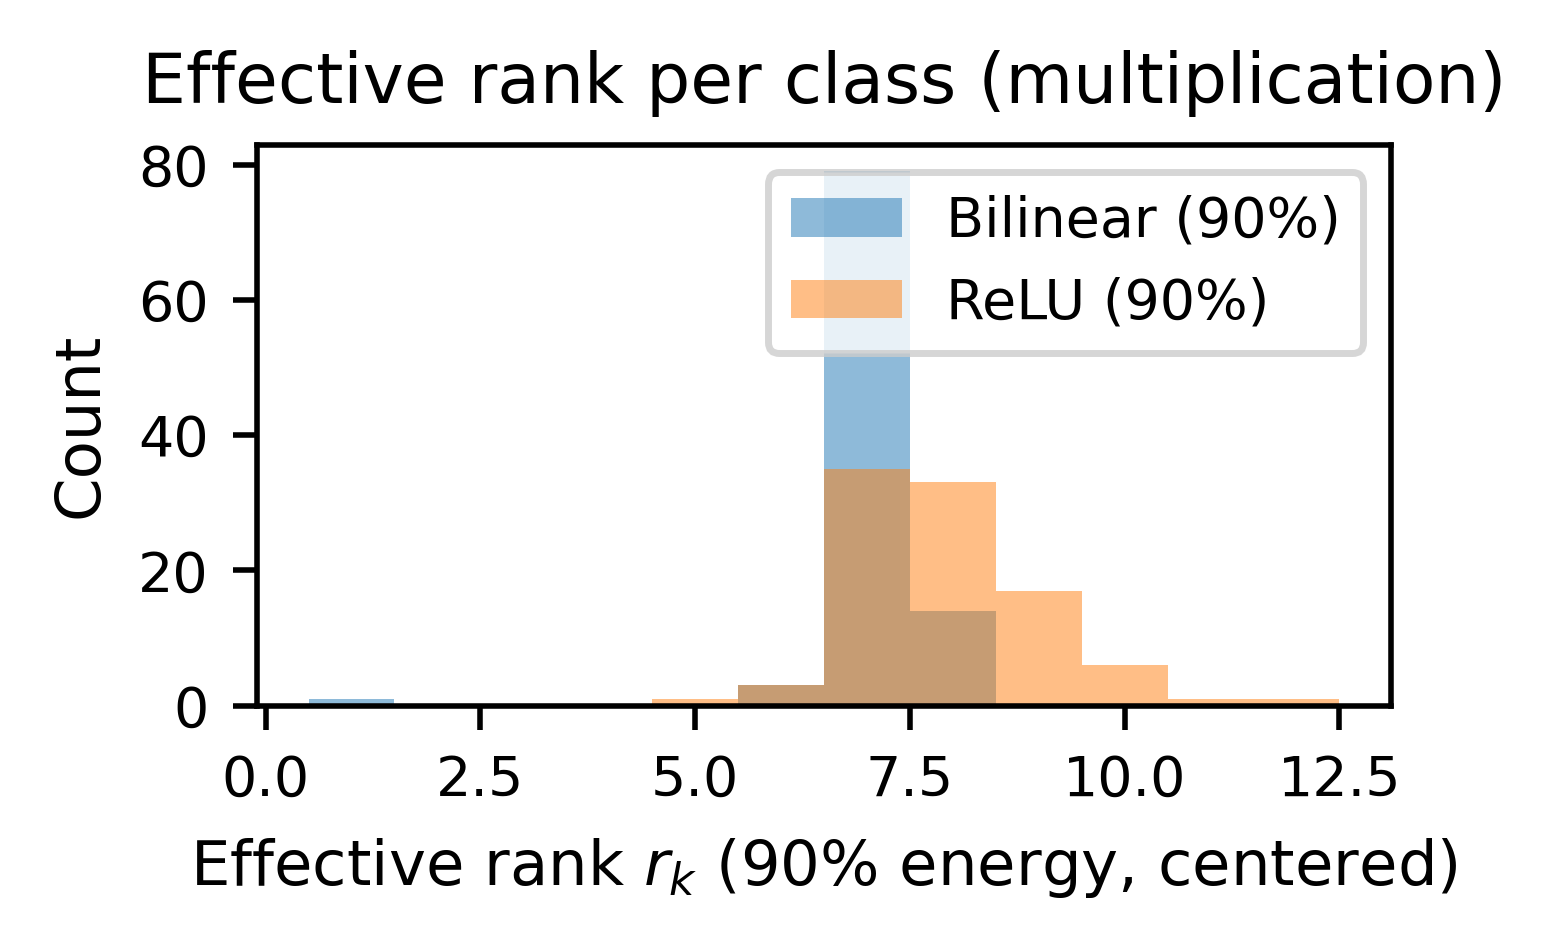

In [97]:
# ============================================================
# 17. Rank histograms (centered) for multiplication
# ============================================================

plt.figure(figsize=(3,2))
plt.hist(r_90_b, bins=range(1, max(r_90_b.max(), r_90_r.max())+2), 
         alpha=0.5, label="Bilinear (90%)", align="left")
plt.hist(r_90_r, bins=range(1, max(r_90_b.max(), r_90_r.max())+2),
         alpha=0.5, label="ReLU (90%)", align="left")
plt.xlabel(r"Effective rank $r_k$ (90% energy, centered)")
plt.ylabel("Count")
plt.title("Effective rank per class (multiplication)")
plt.legend()
plt.tight_layout()
plt.savefig('/kaggle/working/eff_rank_mult_90.pdf', format="pdf", bbox_inches="tight")
plt.show()


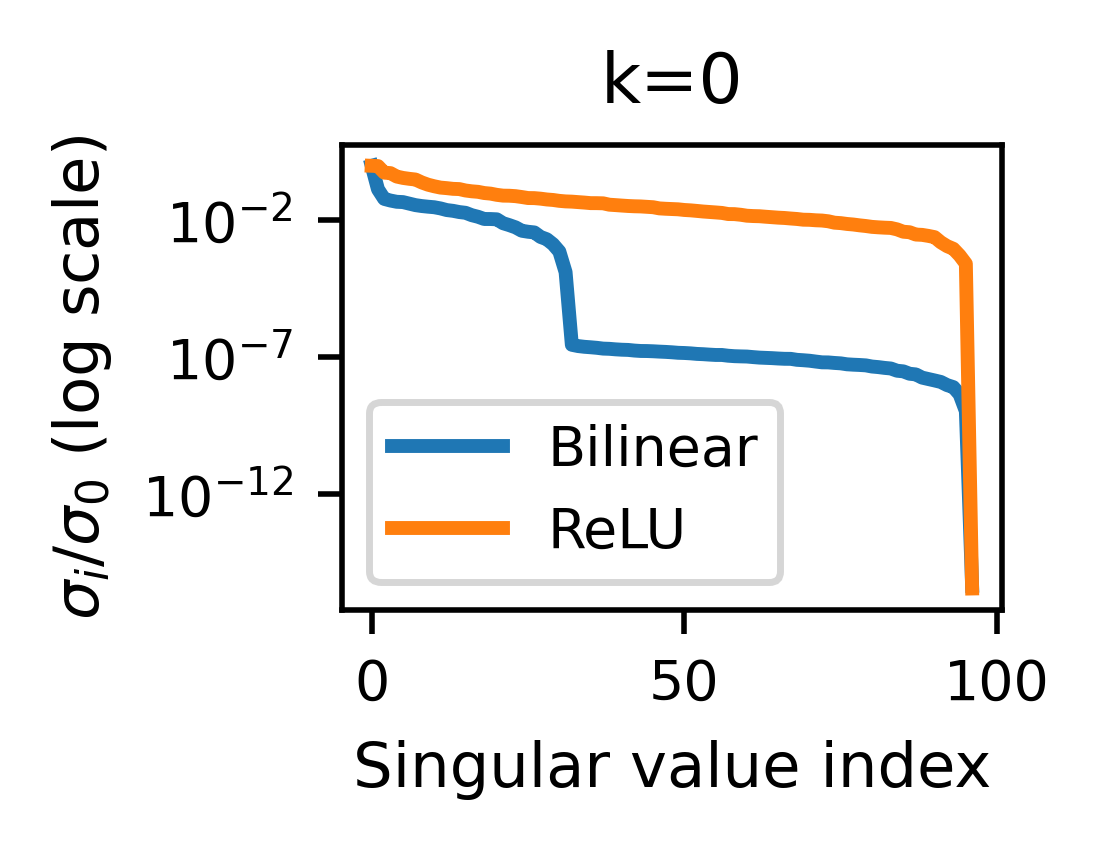

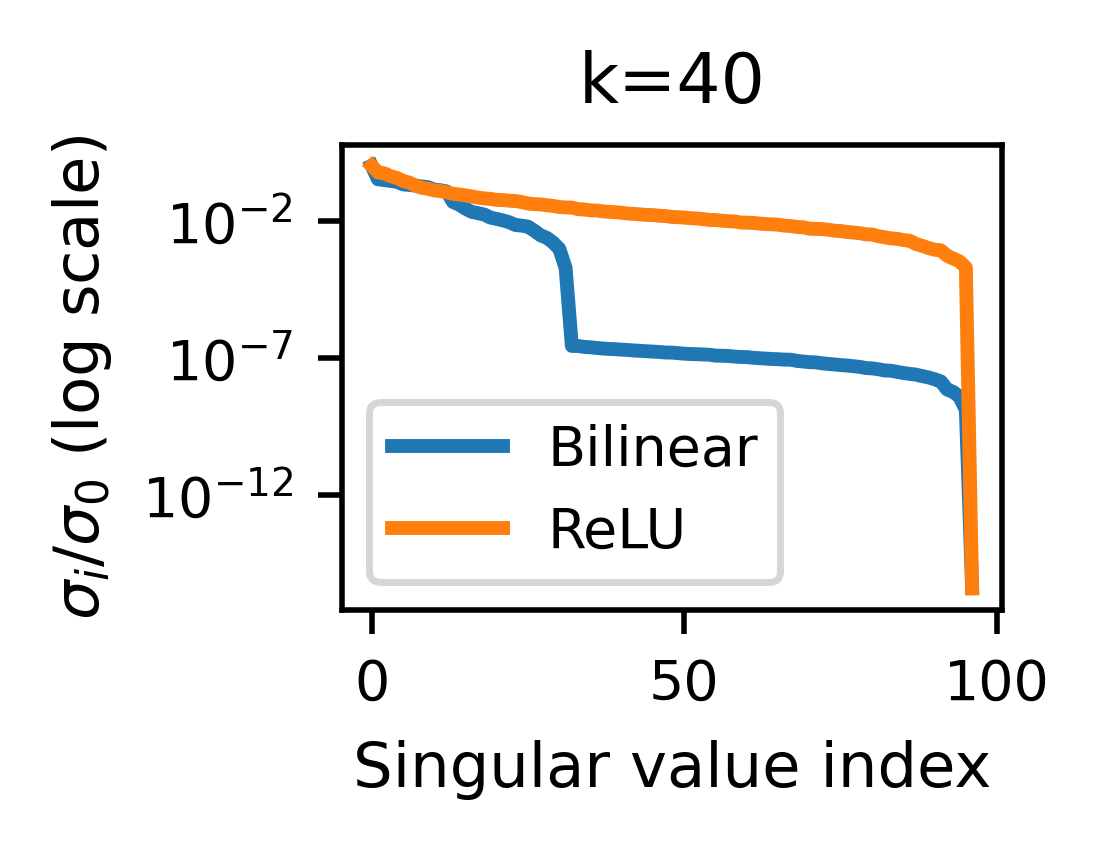

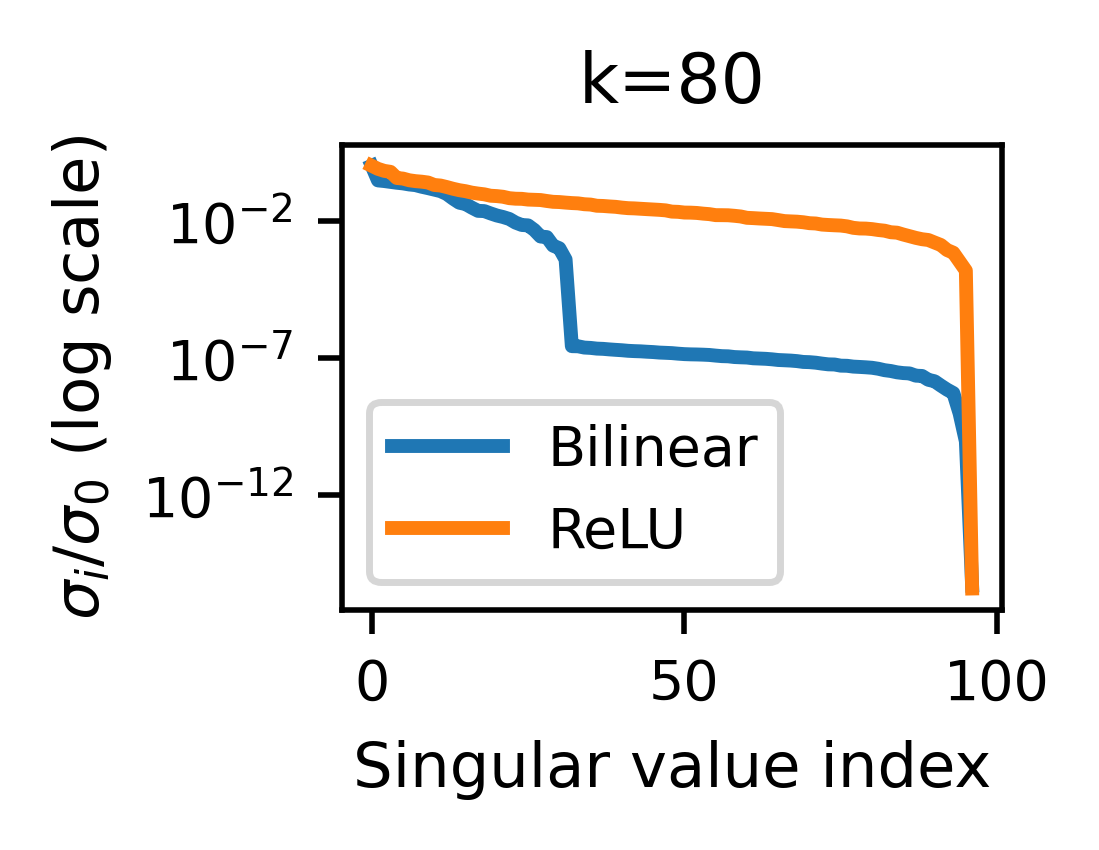

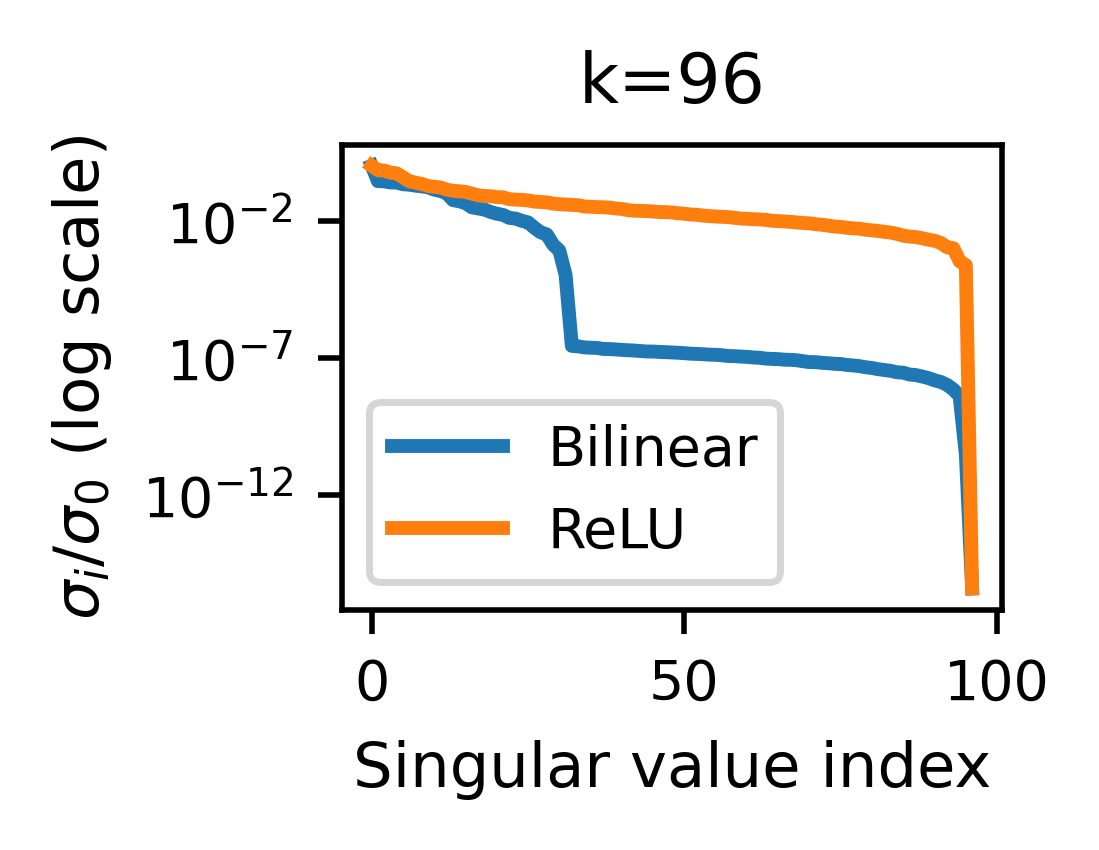

In [98]:
# ============================================================
# 18. Singular value decay plots for example classes (mul)
# ============================================================

def plot_sv_spectrum(Mk_bilin, Mk_relu, k_list=[0, 40, 80, 100]):
    for k in k_list:
        plt.figure(figsize=(2.3, 1.8)) 
        M_b = Mk_bilin[:, :, k].astype(np.float64)
        M_r = Mk_relu[:, :, k].astype(np.float64)

        # (optionally) center as above
        for label, M in [("Bilinear", M_b), ("ReLU", M_r)]:
            M_c = M - M.mean(axis=0, keepdims=True)
            M_c = M_c - M_c.mean(axis=1, keepdims=True)
            M_c = M_c + M_c.mean()

            _, s, _ = np.linalg.svd(M_c, full_matrices=False)
            s_norm = s / s[0]

            plt.plot(s_norm, label=f"{label}",linewidth=2)
        
        plt.yscale("log")
        plt.xlabel("Singular value index")
        plt.ylabel(r"$\sigma_i / \sigma_0$ (log scale)")
        plt.title(f"k={k}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'/kaggle/working/sing_val_decay_{k}.pdf', format="pdf", bbox_inches="tight")
        plt.show()

plot_sv_spectrum(Mk_mul_bilin, Mk_mul_relu, k_list=[0, 40, 80, 96])


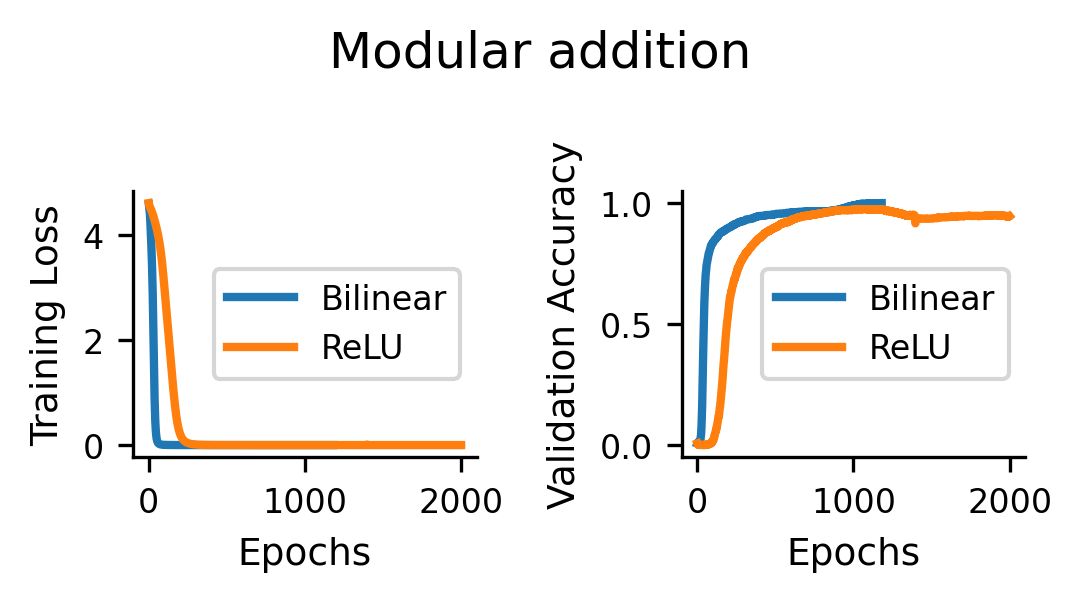

(<Figure size 1110x600 with 2 Axes>,
 array([<Axes: xlabel='Epochs', ylabel='Training Loss'>,
        <Axes: xlabel='Epochs', ylabel='Validation Accuracy'>],
       dtype=object))

In [99]:
import matplotlib.pyplot as plt

def plot_history(history_bil, history_relu, save_path="training_curves.pdf", suptitle="Title"):
    """
    Plot training loss (left) and validation accuracy (right) with a single common title.
    Saves to PDF by default.

    Args:
        history (dict): {"train_loss": [...], "val_acc": [...]}
        save_path (str): path to save figure (should end with .pdf)
        suptitle (str): common title placed above both subplots
    """
    train_loss_bil = history_bil.get("train_loss", [])
    val_acc_bil = history_bil.get("val_acc", [])
    train_loss_relu = history_relu.get("train_loss", [])
    val_acc_relu = history_relu.get("val_acc", [])
    max_epochs = max(len(train_loss_bil), len(val_acc_bil),
                     len(train_loss_relu), len(val_acc_relu))
    epochs = range(1, max_epochs + 1)

    # Figure (paper-quality)
    fig, axes = plt.subplots(1, 2, figsize=(3.7,2), dpi=300, sharex=True)

    # Left: Training loss
    axes[0].plot(range(1, len(train_loss_bil) + 1), train_loss_bil, linewidth=2, label='Bilinear')
    axes[0].plot(range(1, len(train_loss_relu) + 1), train_loss_relu, linewidth=2, label='ReLU')
    axes[0].legend(loc='right')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Training Loss")
    # axes[0].grid(True, linewidth=0.3)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Right: Validation accuracy
    axes[1].plot(range(1, len(val_acc_bil) + 1), val_acc_bil, linewidth=2, label='Bilinear')
    axes[1].plot(range(1, len(val_acc_relu) + 1), val_acc_relu, linewidth=2, label='ReLU')
    axes[1].legend(loc='right')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Validation Accuracy")
    # axes[1].grid(True, linewidth=0.3)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # Single common title
    fig.suptitle(suptitle)
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # make room for suptitle

    # Save as PDF (vector)
    if save_path:
        if not save_path.lower().endswith(".pdf"):
            raise ValueError("save_path should end with .pdf for PDF saving.")
        plt.savefig(save_path, format="pdf", bbox_inches="tight")

    plt.show()
    return fig, axes


plot_history(hist_b_add, hist_r_add, "/kaggle/working/addition.pdf", suptitle="Modular addition")